In [11]:
import pandas as pd
import seaborn as sns

from common import mst_csv_path, vertices_csv_path


def plot_mst(dataset: str):
    vertices = pd.read_csv(vertices_csv_path(dataset), names=["lat", "lon"])
    mst_edges = pd.read_csv(
        mst_csv_path(dataset), names=["p1x", "p1y", "p2x", "p2y", "w"]
    )

    ax = sns.scatterplot(data=vertices, x="lat", y="lon", s=1)
    for _, row in mst_edges.iterrows():
        ax.plot((row["p1x"], row["p2x"]), (row["p1y"], row["p2y"]), linewidth=0.5)

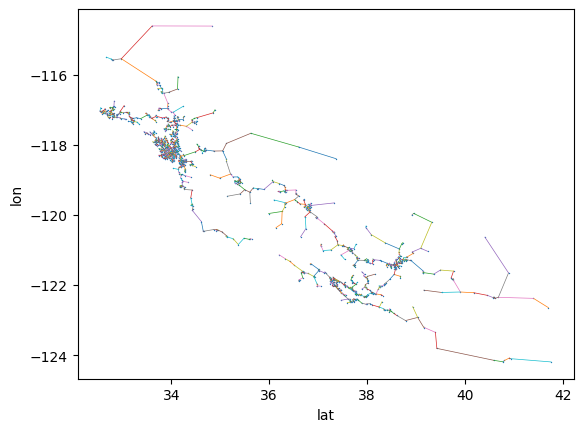

In [12]:
plot_mst("mcdonalds")

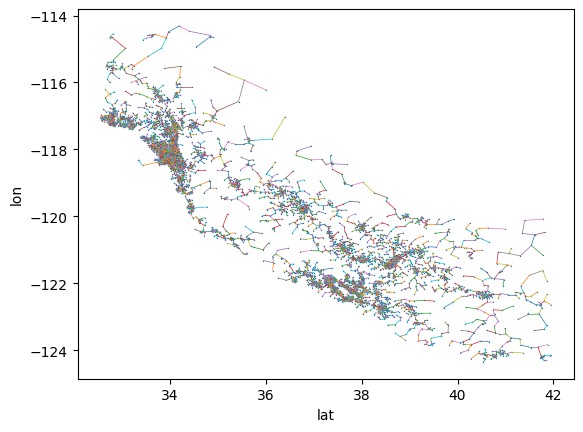

In [13]:
plot_mst("housing")